### Diabetes Prediction

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

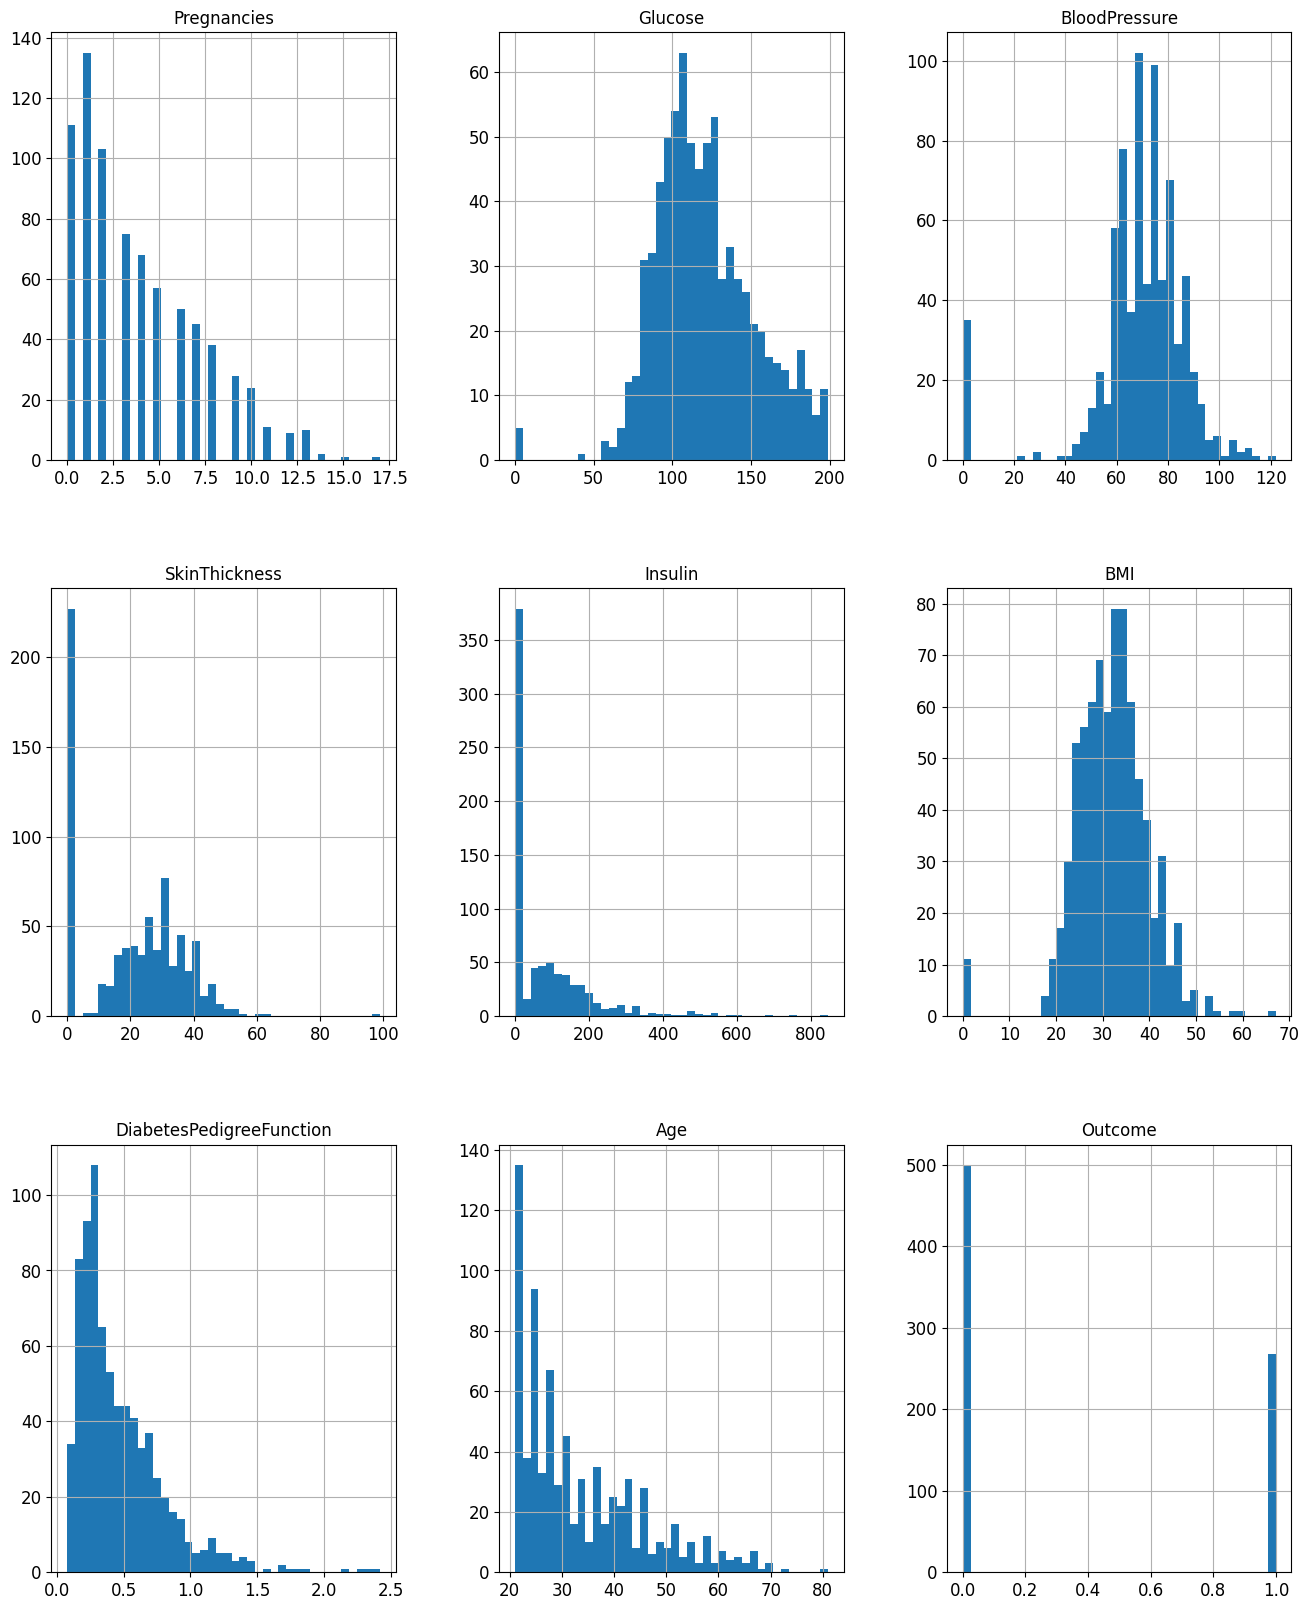

In [10]:
df.hist(figsize=(16, 20), bins=40, ylabelsize=12, xlabelsize=12)

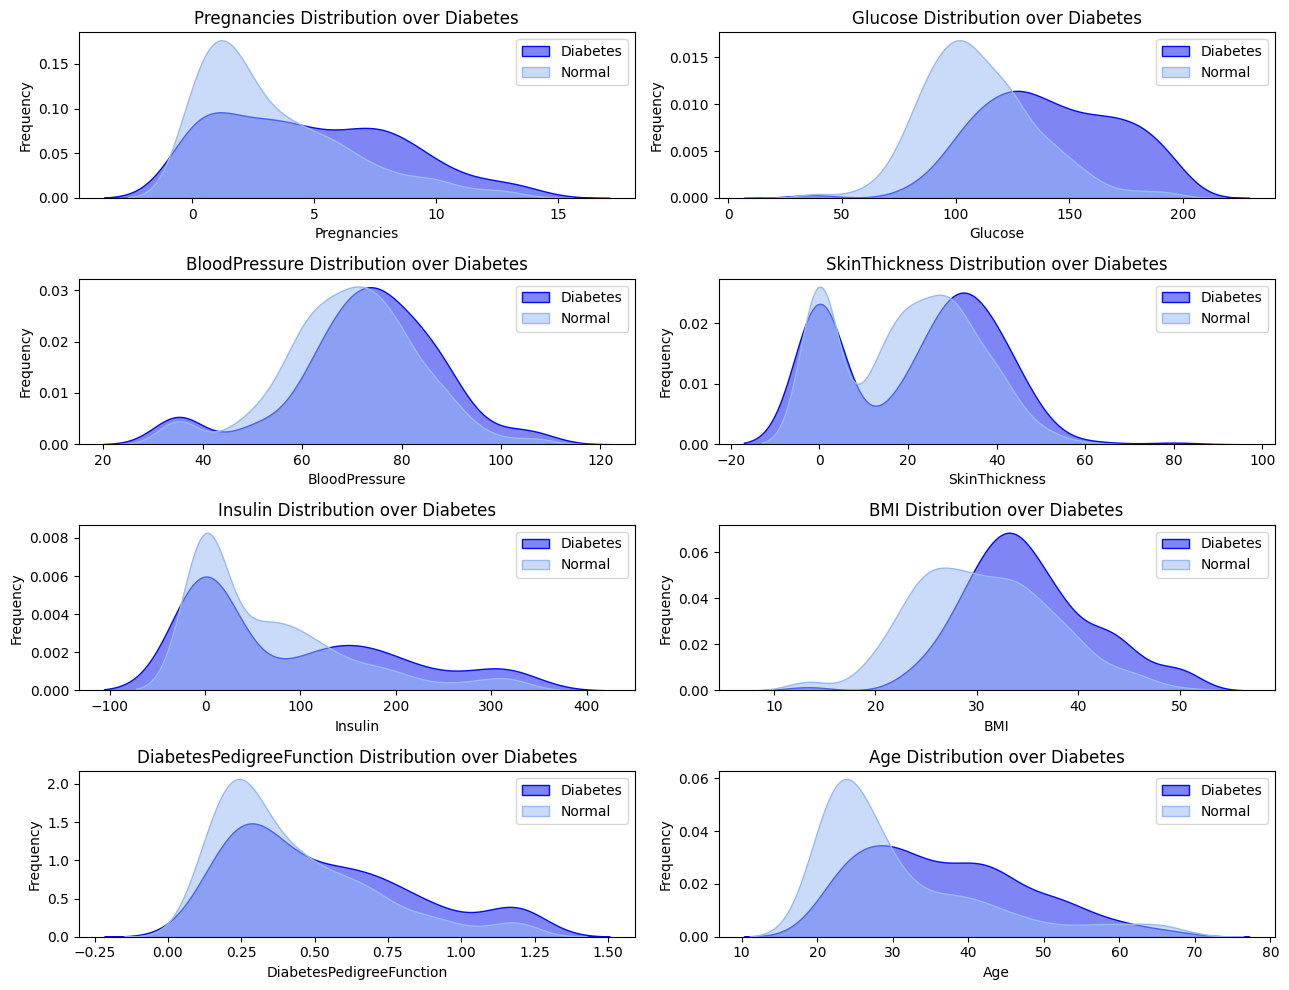

In [21]:
fig, axes = plt.subplots(nrows=len(df.columns) // 2, ncols=2, figsize=(13, 10))

for idx, column in enumerate(df.drop(columns = 'Outcome')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.kdeplot(df[df["Outcome"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="Diabetes", ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["Outcome"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="Normal", ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Frequency")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Diabetes")
    axes[row_idx, col_idx].legend()

plt.tight_layout()
plt.show()

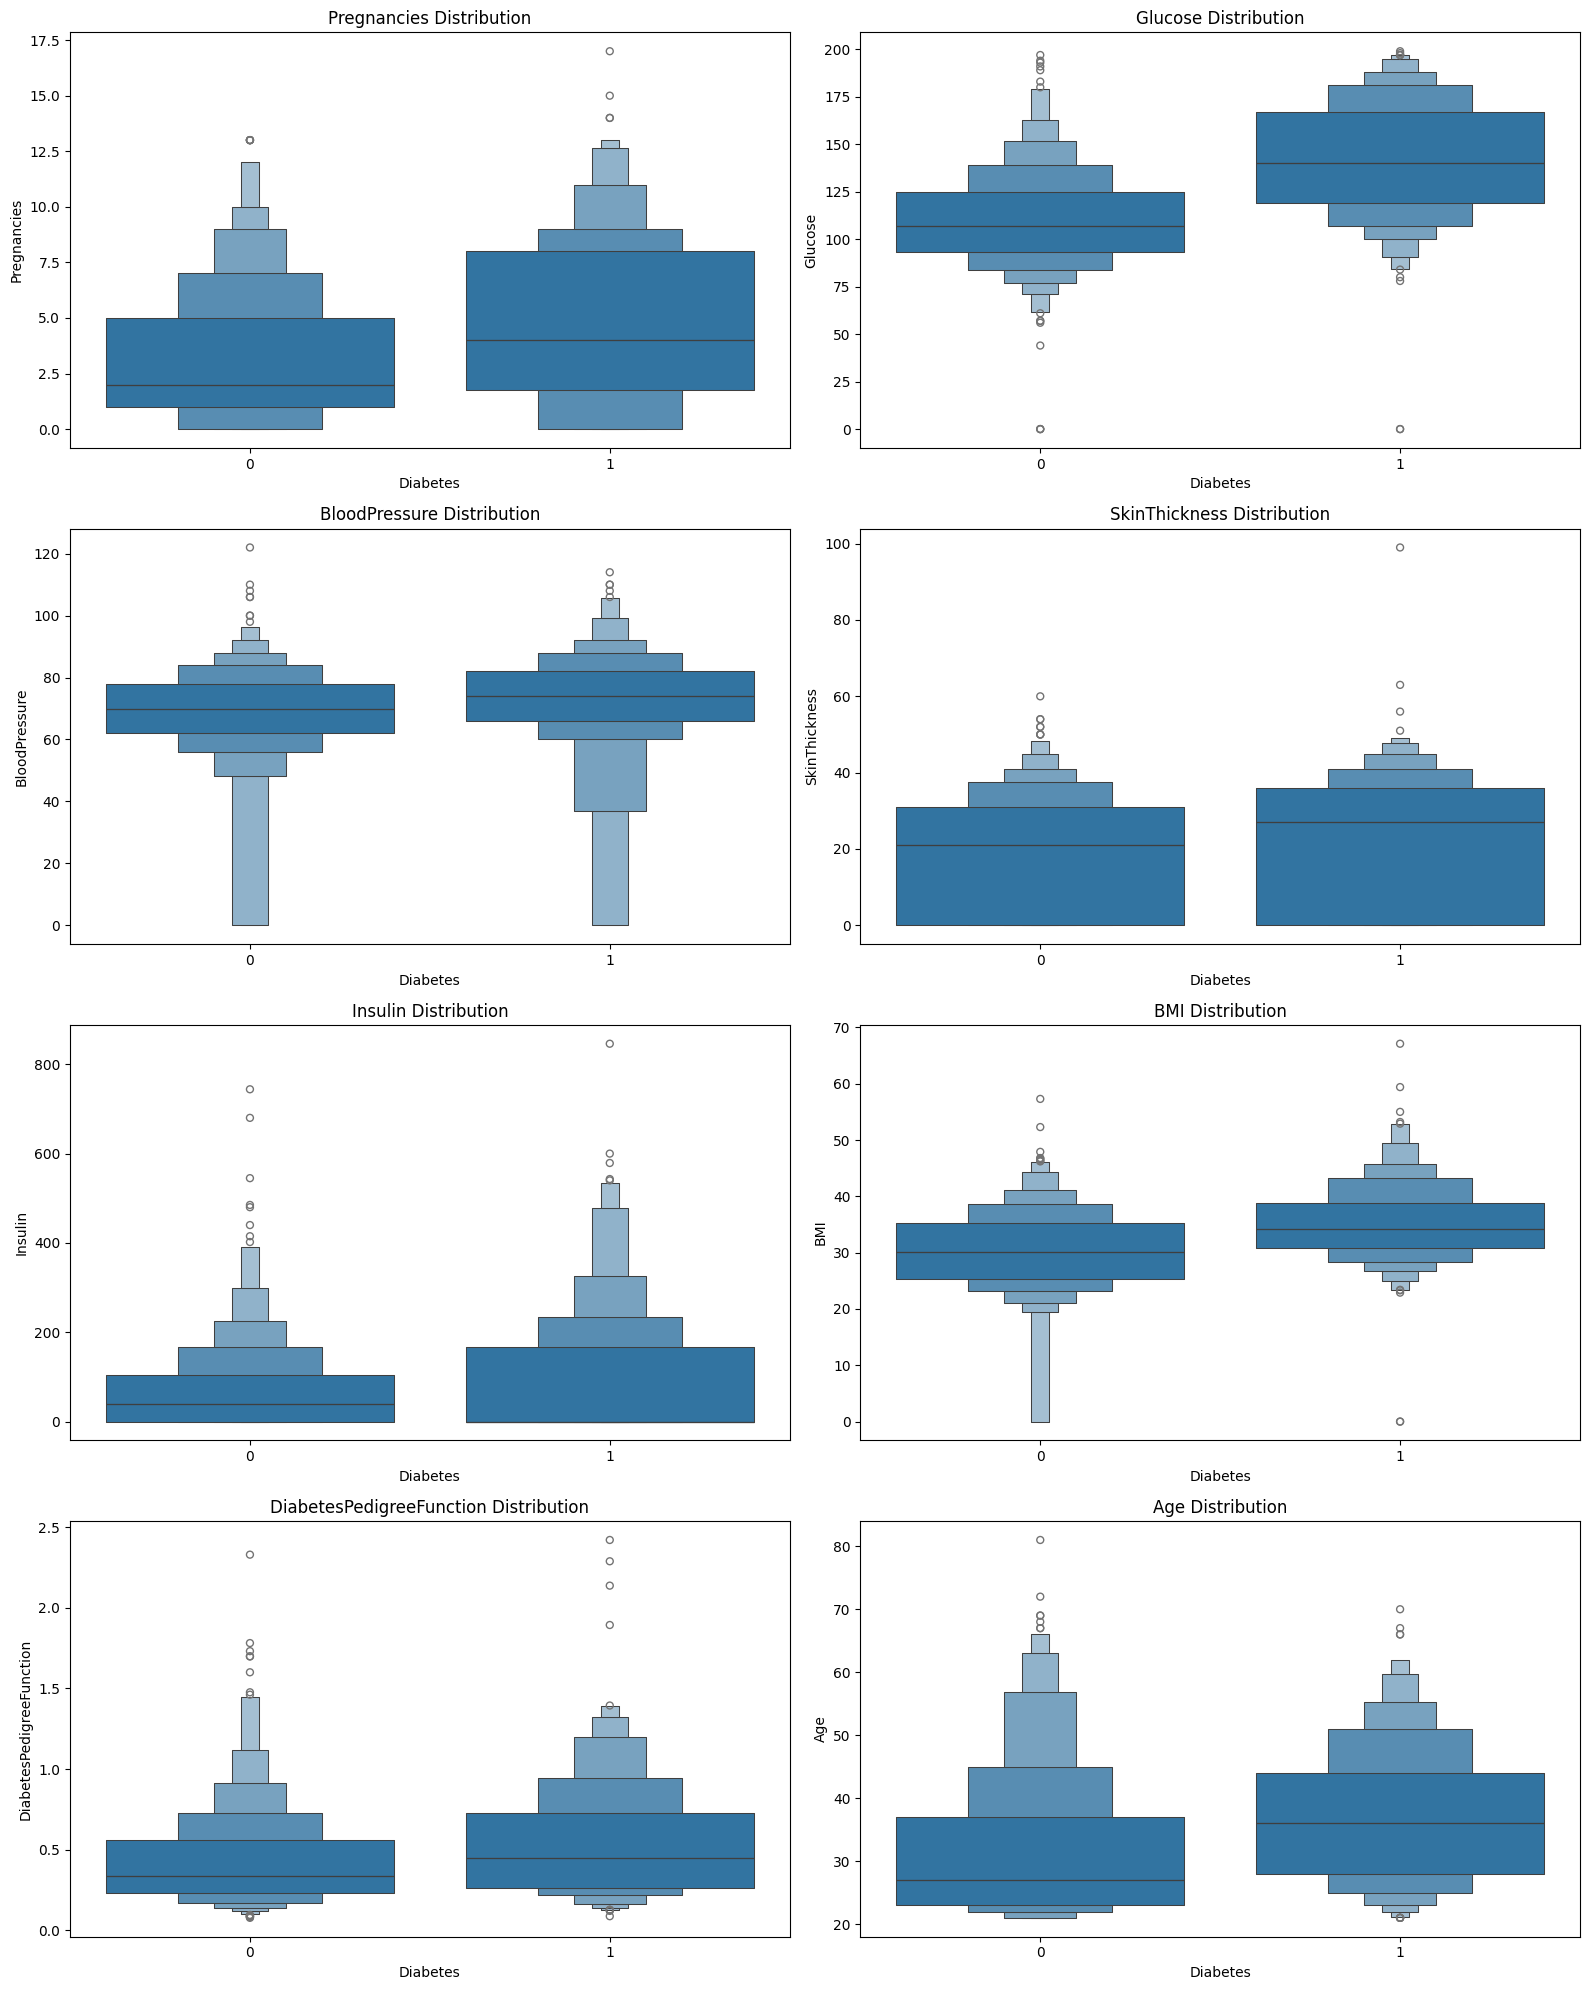

In [13]:
fig, axes = plt.subplots(nrows=len(df.columns) // 2, ncols=2, figsize=(16, 20))

for idx, column in enumerate(df.drop(columns = 'Outcome')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.boxenplot( x='Outcome' , y= column , data=df, ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel("Diabetes")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

In [14]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing the outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

for column in (df.drop(columns = 'Outcome').columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [22]:
X = df.drop(columns = 'Outcome')
target = df['Outcome']

X_train , X_test , y_train , y_test = train_test_split(X ,target ,test_size=0.2 , random_state=42 )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (614, 8)
y_train shape: (614,)
X_test shape: (154, 8)
y_test shape: (154,)


In [23]:
def train(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 42)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

**SVM**

In [24]:
svm_classifier = make_pipeline(
    MinMaxScaler(),
    svm.SVC(C = 0.5, gamma = 'auto', kernel = 'linear')
)

Cross Validation Score :  83.31%
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        99
           1       0.70      0.64      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154



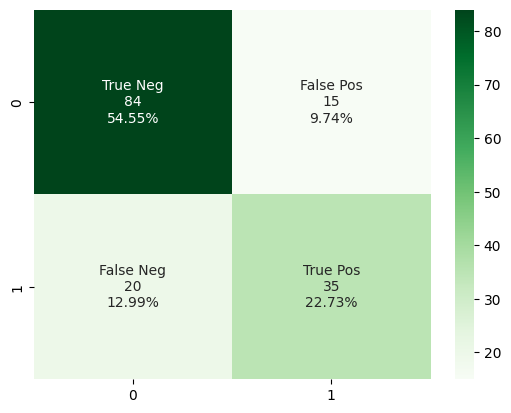

In [25]:
# Training the model
train(svm_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(svm_classifier, X_test, y_test)

**Random Forest**

In [26]:
rf_classifier = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

Cross Validation Score :  82.33%
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



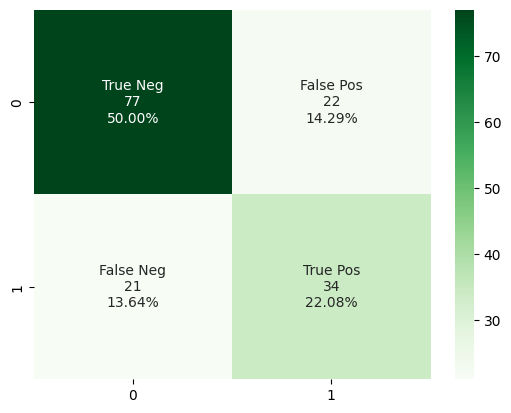

In [27]:
# Training the model
train(rf_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(rf_classifier, X_test, y_test)

**XGBoost**

In [28]:

xgb_classifier = make_pipeline(
    MinMaxScaler(),
    xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42)
)

Cross Validation Score :  81.69%
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        99
           1       0.56      0.64      0.59        55

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.70      0.69      0.69       154



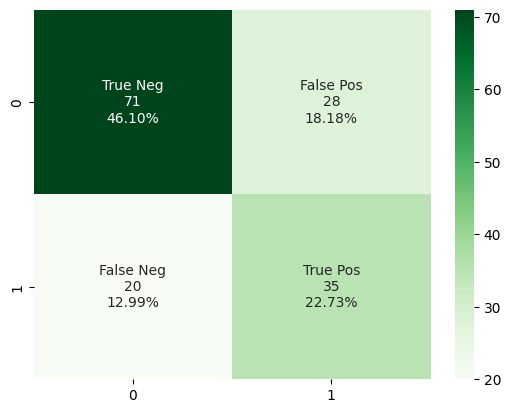

In [29]:
# Training the model
train(xgb_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(xgb_classifier, X_test, y_test)